In [67]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Overview

This is a modification of Problem 8-29c from the book Elements of Chemical Reaction Engineering (Fogler, 1999).

The problem consists of modeling the isomerization of xylene in a tubular reactor. It was converted to an optimization problem based on maximizing one of the isomers produced.

There is equimolar feed of o-xylene and m-xylene, and our goal is maximizing the o-xylene produced.

## Reference

Fogler, H. S., 1999. Elements Of Chemical Reaction Engineering. 3rd ed. Upper Saddle River(N.J.): Prentice Hall PTR.

## Problem statement

**Convention for components:**\
1: *o-xylene*\
2: *m-xylene*\
3: *p-xylene*

**Reactions**\
$r_1: \textit{o-xylene} \leftrightarrow \textit{m-xylene}$\
$r_3: \textit{o-xylene} \rightarrow \textit{p-xylene}$

**ODE system:**

**ODEs**
\begin{align}
    &\frac{dC_{1}}{dW} = (r_1 + r_3) / v\\
    &\frac{dC_{2}}{dW} = -r_1 / v\\
    &\frac{dC_{3}}{dW} = -r_3 / v\\
    &\frac{dT}{dW} = \frac{r_1 \Delta H_1 + r_3 \Delta H_3 + Ua / \rho_b (T_a - T)}{\sum_{i=1}^{3} F_i Cp_i}
\end{align}

**Initial values**
\begin{align}
    &T(0) = 330 \: [K]\\
    &C_1(0) = 1 \: [mol/L]\\
    &C_2(0) = 1 \: [mol/L]\\
    &C_3(0) = 0 \: [mol/L]
\end{align}

**Parameters**
\begin{align}
    &v = 1 \: [L/min]\\
    &F_i = C_i v\\
    &Cp_i = 100 \: [J/(mol \: K)]\\
    &\Delta H_1 = -1800 \: [J/(mol)]\\
    &\Delta H_3 = -1100 \: [J/(mol)]\\
    &Ua / \rho_b = 16 \: [J/(kg \: min \: °C)]
\end{align}

In [68]:
#Total molar flow rate (mol/min)
Ft0 = 2

#Concentration of species at reactor inlet (mol/L)
ct0 = 2

#Volumetric flow rate (L/min)
v = Ft0/ct0

#Initial fraction
y0 = np.array([0.5, 0.5, 0.0])

#Individual concentrations at inlet (mol/L)
c0 = y0 * ct0

#Individual inlet molar flow rates (mol/min)
F0 = y0 * Ft0

#Heat capacities
Cp = 100.0

#Heat of reactions (J/mol.o-xylene)
dh1 = -1800
dh3 = -1100

#Heat transfer coefficient (J/kg.min.°C)
U = 16

In [69]:
#Define the ODE system
def ode_system(w, y, Ta=500):
    
    #Temperature and concentrations (K); (mol/L)
    T = y[0]
    c = y[1:]
    
    #Molar flow rates (mol/min)
    F = c * v
    
    #Kinetic constants (L/kg.cat min)
    k1 = 0.5 * np.exp(2 * (1 - 320 / T))
    Kc = 10 * np.exp(4.8 * (430 / T - 1.5))
    k2 = k1 / Kc
    k3 = 0.005 * np.exp(4.6 * (1 - 460 / T))
    
    #Reaction rates (mol.o-xylene/min kg.cat)
    r1 = - k1 * c[0] + k2 * c[1]
    r3 = - k3 * c[0]
    
    #Differentials (mol.o-xylene/L kg.cat)
    dc = np.array([r1 + r3, -r1, -r3]) / v
    
    #Energy balance (K/kg.cat)
    rdh = r1 * dh1 + r3 * dh3
    dT = (U * (Ta - T) + rdh) / (F * Cp).sum()
    
    return np.hstack([dT, dc])

## Baseline solution

In [70]:
#Initial conditions
T0 = 330.0
y0 = np.hstack([T0, c0])

#Catalyst loading
W = 100

In [71]:
sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', t_eval=np.linspace(0, W, 200))

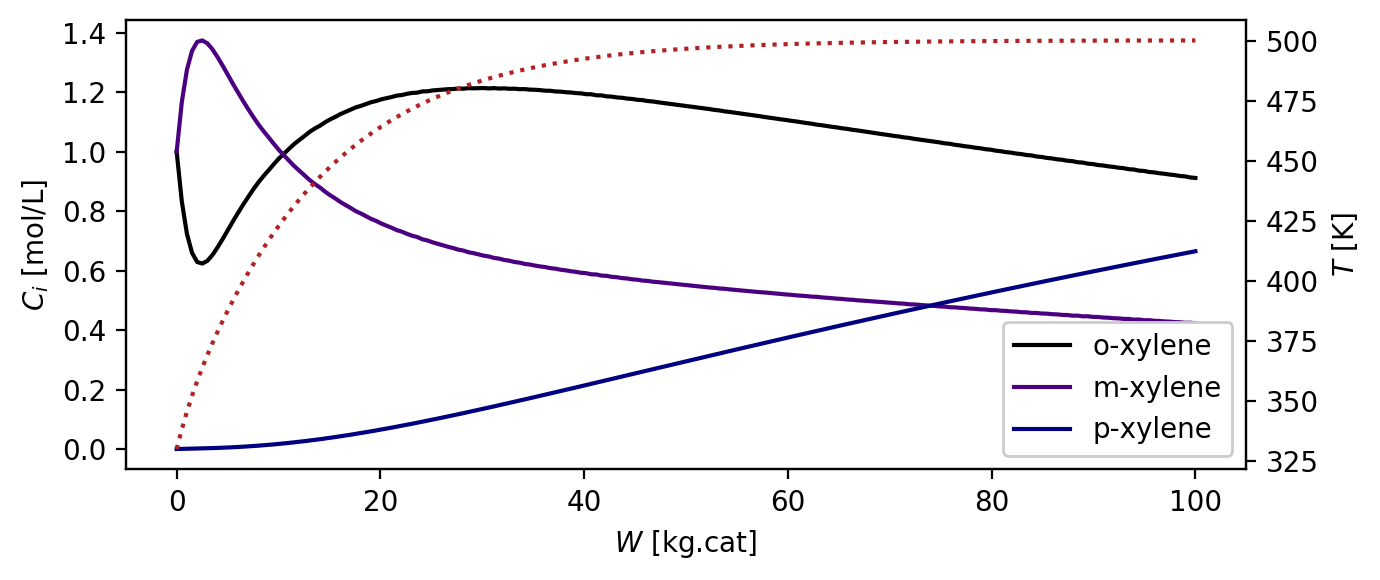

In [72]:
fig, ax1 = plt.subplots(figsize = (7, 3), dpi=200)

ax1.plot(sol_ode.t, sol_ode.y[1], color='black', label="o-xylene")
ax1.plot(sol_ode.t, sol_ode.y[2], color='indigo', label="m-xylene")
ax1.plot(sol_ode.t, sol_ode.y[3], color='navy', label="p-xylene")

ax1.set_ylabel(r'$C_i$ [mol/L]')
ax1.set_xlabel(r'$W$ [kg.cat]')
ax1.legend(loc="lower right", framealpha=1.0)

ax2 = ax1.twinx()
ax2.plot(sol_ode.t, sol_ode.y[0], color='firebrick', linestyle=":")
ax2.set_ylabel(r'$T$ [K]')

fig.tight_layout()

plt.show()

## Optimization

**Variables**\
${W, T(0), T_a}$

**Objective**\
$C_1(W) - C_1(0)$

**Functional constraint**\
$T(W) \leq 450$

**Bounds**\
$0.1 \leq W \leq 100$\
$200 \leq T(0) \leq 500$\
$200 \leq T_a \leq 500$

In [73]:
def obj_conv(x):
    
    W = x[0]
    T0 = x[1]
    Ta = x[2]
    
    y0 = np.hstack([T0, c0])
    
    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,))
    
    y = sol_ode.y[:, -1]
    T = y[0]
    cox = y[1]
    cmx = y[2]
    cpx = y[3]
    
    xox = (cox - c0[0])
    xmx = (cmx - c0[1])
    xpx = (cpx - c0[2])
    
    return  - xox

def obj_multi_1(x):
    
    W = x[0]
    T0 = x[1]
    Ta = x[2]
    
    y0 = np.hstack([T0, c0])
    
    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,))
    
    y = sol_ode.y[:, -1]
    T = y[0]
    cox = y[1]
    cmx = y[2]
    cpx = y[3]
    
    xox = (cox - c0[0])
    xmx = (cmx - c0[1])
    xpx = (cpx - c0[2])
    
    return  - xox

def obj_multi_2(x):
    
    W = x[0]
    T0 = x[1]
    Ta = x[2]
    
    y0 = np.hstack([T0, c0])
    
    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,))
    
    y = sol_ode.y[:, -1]
    T = y[0]
    cox = y[1]
    cmx = y[2]
    cpx = y[3]
    
    xox = (cox - c0[0])
    xmx = (cmx - c0[1])
    xpx = (cpx - c0[2])
    
    return  - xpx

def cons_func(x):
    
    W = x[0]
    T0 = x[1]
    Ta = x[2]
    
    y0 = np.hstack([T0, c0])
    
    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,))
    
    y = sol_ode.y[:, -1]
    T = y[0]
    
    return  450 - T

def cons_func_pymoo(x):
    
    W = x[0]
    T0 = x[1]
    Ta = x[2]
    
    y0 = np.hstack([T0, c0])
    
    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,))
    
    y = sol_ode.y[:, -1]
    T = y[0]
    
    return  np.array([T - 450])

In [74]:
bounds = [(0.1, 100), (100, 550), (100, 550)]

In [75]:
sol_bounded = minimize(obj_conv, np.array([50, 350, 500]), bounds=bounds)

In [76]:
sol_bounded

      fun: -0.4906321673202654
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.22044606e-07, -2.29327486e-03, -1.79744965e-04])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 204
      nit: 23
     njev: 51
   status: 0
  success: True
        x: array([  1.14927378, 550.        , 550.        ])

In [77]:
sol_constrained = minimize(obj_conv, np.array([50, 350, 500]), method="SLSQP", bounds=bounds,
                           constraints={"fun":cons_func, "type":"ineq"})

In [78]:
sol_constrained

     fun: -0.1143011897779711
     jac: array([-0.01057354, -0.00094798, -0.00354828])
 message: 'Optimization terminated successfully'
    nfev: 91
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 19.11827102, 347.06971629, 480.09872642])

## Visual

In [79]:
def ode_from_opt(x, t_eval=None):
    
    W = x[0]
    T0 = x[1]
    Ta = x[2]
    
    y0 = np.hstack([T0, c0])
    
    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,), t_eval=t_eval)
    
    return  sol_ode

In [80]:
sol_ode_bounded = ode_from_opt(sol_bounded.x, t_eval=np.linspace(0, sol_bounded.x[0], 200))
sol_ode_constrained = ode_from_opt(sol_constrained.x, t_eval=np.linspace(0, sol_constrained.x[0], 200))

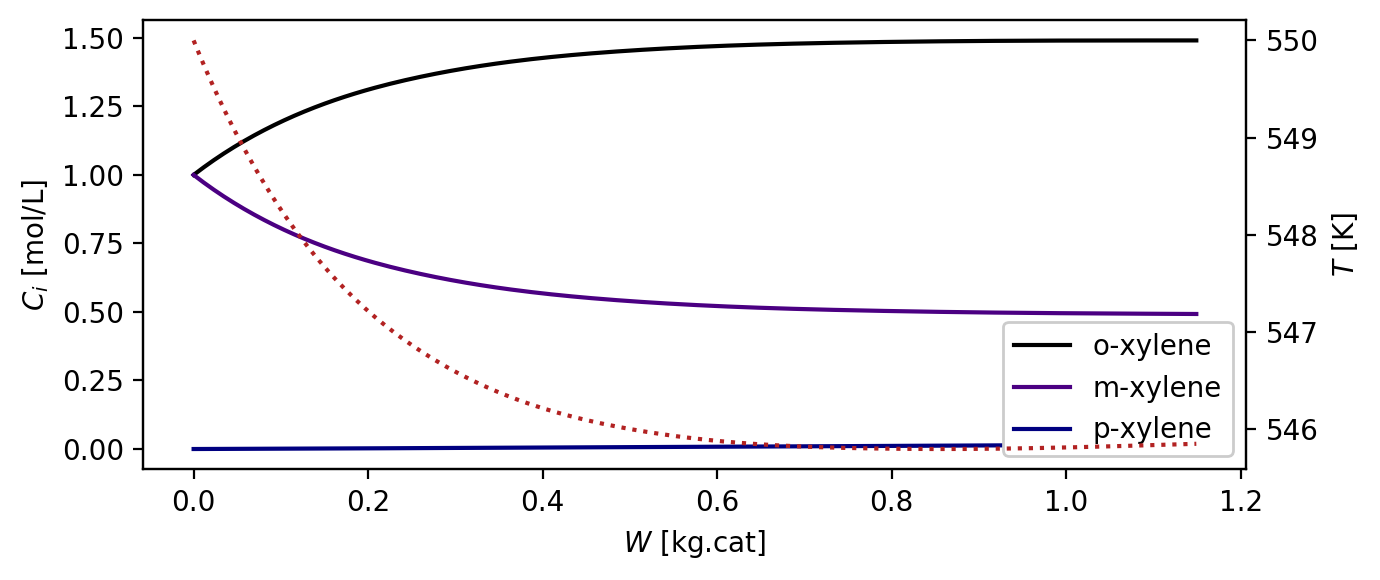

In [81]:
fig, ax1 = plt.subplots(figsize = (7, 3), dpi=200)

ax1.plot(sol_ode_bounded.t, sol_ode_bounded.y[1], color='black', label="o-xylene")
ax1.plot(sol_ode_bounded.t, sol_ode_bounded.y[2], color='indigo', label="m-xylene")
ax1.plot(sol_ode_bounded.t, sol_ode_bounded.y[3], color='navy', label="p-xylene")

ax1.set_ylabel(r'$C_i$ [mol/L]')
ax1.set_xlabel(r'$W$ [kg.cat]')
ax1.legend(loc="lower right", framealpha=1.0)

ax2 = ax1.twinx()
ax2.plot(sol_ode_bounded.t, sol_ode_bounded.y[0], color='firebrick', linestyle=":")
ax2.set_ylabel(r'$T$ [K]')

fig.tight_layout()

plt.show()

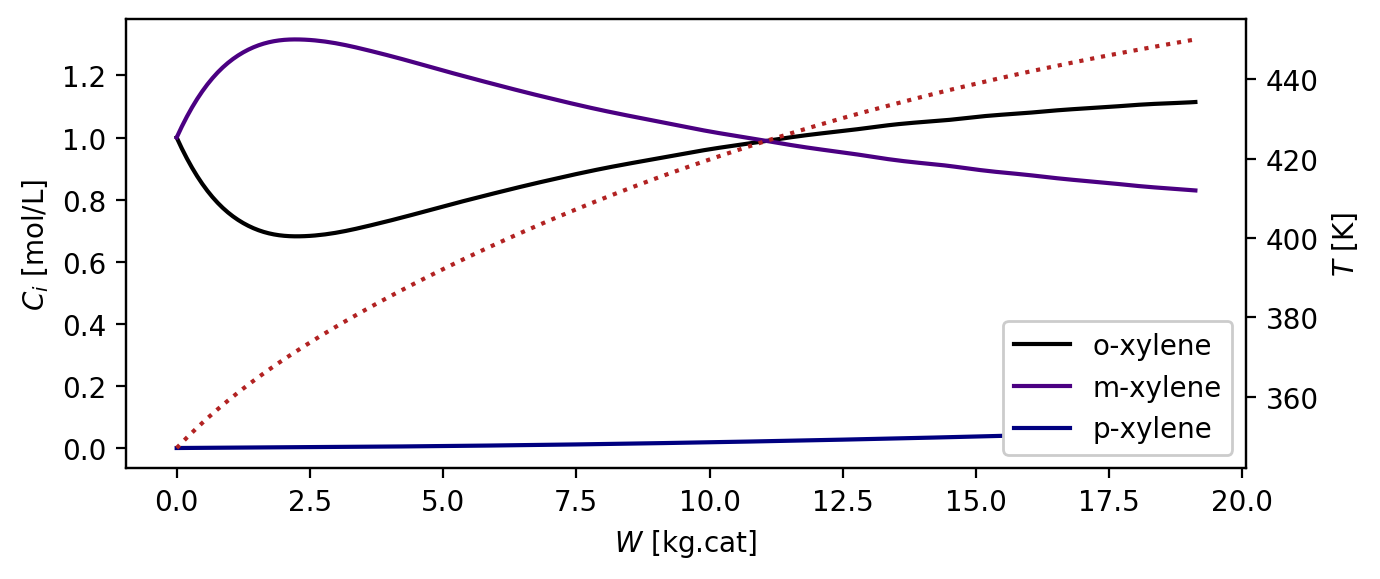

In [82]:
fig, ax1 = plt.subplots(figsize = (7, 3), dpi=200)

ax1.plot(sol_ode_constrained.t, sol_ode_constrained.y[1], color='black', label="o-xylene")
ax1.plot(sol_ode_constrained.t, sol_ode_constrained.y[2], color='indigo', label="m-xylene")
ax1.plot(sol_ode_constrained.t, sol_ode_constrained.y[3], color='navy', label="p-xylene")

ax1.set_ylabel(r'$C_i$ [mol/L]')
ax1.set_xlabel(r'$W$ [kg.cat]')
ax1.legend(loc="lower right", framealpha=1.0)

ax2 = ax1.twinx()
ax2.plot(sol_ode_constrained.t, sol_ode_constrained.y[0], color='firebrick', linestyle=":")
ax2.set_ylabel(r'$T$ [K]')

fig.tight_layout()

plt.show()